<a href="https://colab.research.google.com/github/kjxeez/machine-learning/blob/main/Poly_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Методы машинного обучения – Лабораторная работа №2

# Нелинейная регрессия

Линейной регрессии может быть недостаточно для выявления взаимосвязи между признаками $X_{1},X_{2},...,X_{d}$ и откликом $Y$ в случае, когда эта взаимосвязь является нелинейной, поэтому приходится рассматривать более общий случай, когда 

$$Y=f\left(\mathbf{X}\right)+\varepsilon=f\left(X_{1},X_{2},...,X_{d}\right)+\varepsilon,$$

где $\varepsilon$ – случайная ошибка, которая предполагается независимой от многомерной случайной величины $\mathbf{X}=\left(X_{1},X_{2},...,X_{d}\right)^{T}\in\mathbb{R}^{d}$, причем $\mathbb{E}\left[\varepsilon\right]=0$. 

Импортируем необходимые библиотеки:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

При рассмотрении нелинейной регресии часто применяют градиентные методы.

### Моделирование градиентного спуска

Градиентный спуск — метод нахождения локального минимума или максимума функции с помощью движения вдоль градиента. 

Изобразим график функции $y = (x-2.5)^2-1$:

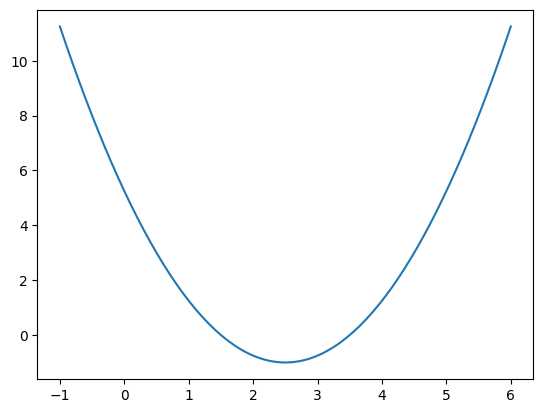

In [2]:
plot_x = np.linspace(-1., 6., 141)
plot_y = (plot_x-2.5)**2 - 1.
plt.plot(plot_x, plot_y);

Минимум этой функции достигается в точке $x=2.5$ и равен $-1$.

Для вычисления значений и производной функции $y = (x-2.5)^2-1$ будем использовать следующие функции:

In [3]:
def J(x_):
    return (x_-2.5)**2 - 1.

def dJ(x_):
    return 2*(x_-2.5)

Для моделирования градиентного спуска будем использовать функцию `gradient_descent()`, которая будет запоминать и возвращать историю итераций, для визуализации градиентного спуска будем использовать функцию `plot_history()`:

In [5]:
def gradient_descent(initial_x, eta, n_iters = 1e4, epsilon=1e-8):
    x_ = initial_x
    x_history = [initial_x]
    i_iter = 0

    while i_iter < n_iters:
        gradient = dJ(x_)
        last_x_ = x_
        x_ -= eta * gradient
        x_history.append(x_)
    
        if(abs(J(x_) - J(last_x_)) < epsilon):
            break
        i_iter += 1
        
    return x_history
            
def plot_history(plot_x, x_history):
    plt.plot(plot_x, J(plot_x))
    plt.plot(np.array(x_history), J(np.array(x_history)), color="r", marker='+')
    plt.text(1., 10., f'Кол-во шагов: {len(x_history)}', fontsize=14, color='r')

Проведем моделирование градиентного спуска с различной скоростью:

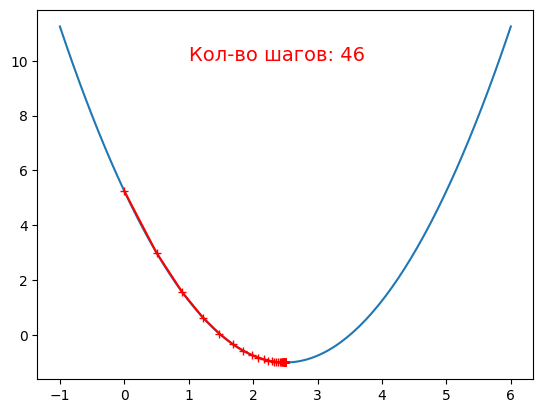

In [6]:
hist = gradient_descent(0., 0.1) # скорость 0.1
plot_history(plot_x, hist)

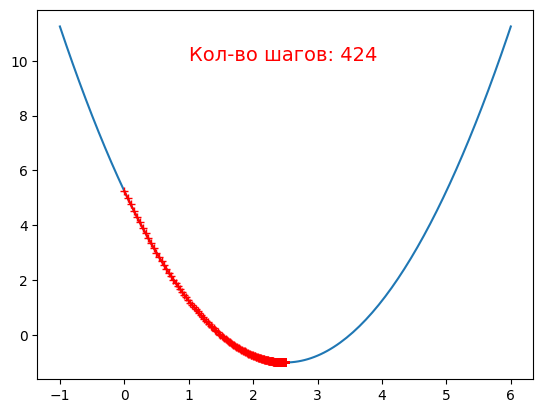

In [7]:
hist = gradient_descent(0., 0.01) # скорость 0.01
plot_history(plot_x, hist)

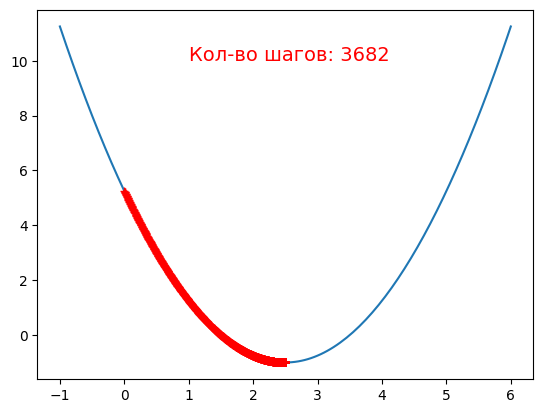

In [8]:
hist = gradient_descent(0., 0.001) # скорость 0.001
plot_history(plot_x, hist)

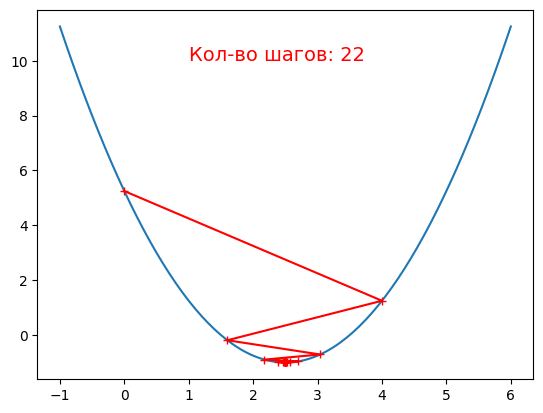

In [9]:
hist = gradient_descent(0., 0.8) # скорость 0.8
plot_history(plot_x, hist)

При дальнейшем увеличении скорости возникает ошибка, которую нужно обработать:

In [10]:
try:
    hist = gradient_descent(0., 1.1) # скорость 1.1
    plot_history(plot_x, hist)
except Exception as e: 
    print(f"{type(e).__name__}: {e}")

OverflowError: (34, 'Numerical result out of range')


Поэтому ограничимся десятью итерациями:

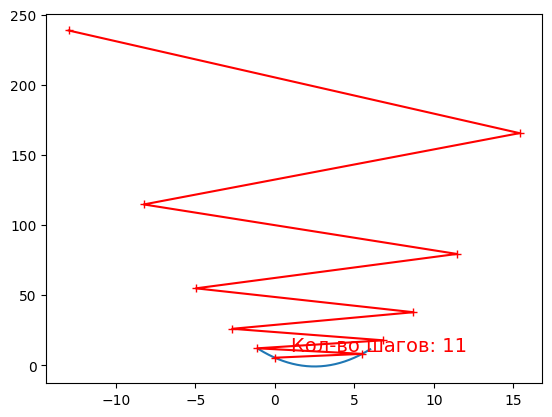

In [11]:
hist = gradient_descent(0., 1.1, n_iters=10)
plot_history(plot_x, hist)

при градиентных методах скорость оч важна

Таким образом, при использовании градиентного спуска важную роль играет скорость (размер шага). 

### Стохастический градиентный спуск

Стохастический градиентный спуск (stochastic gradient descent, SGD) − оптимизационный алгоритм, отличающийся от обычного градиентного спуска тем, что градиент оптимизируемой функции считается на каждом шаге не как сумма градиентов от каждого элемента выборки, а как градиент от одного, случайно выбранного элемента или некоторой подвыборки.

Рассмотрим следующий синтетический набор данных:

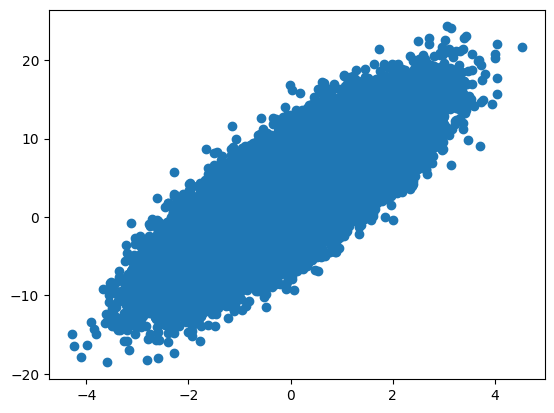

In [12]:
m = 100000 # количество точек в наборе

x = np.random.normal(size=m) #вектор
X = x.reshape(-1,1)           # преобразуем вектор в матрицу с одним столбцом
#х для рисования, Х - нейронка (вектор не воспримет)
y = 4.*x + 3. + np.random.normal(0, 3, size=m)

plt.scatter(x, y);

Определим класс `RegressionSGD`, использующий стохастический градиентный спуск (с переменным шагом) при обучении модели:

In [13]:
class RegressionSGD:

    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
        self._theta = None

    def fit(self, X_train, y_train, n_iters=50, t0=5, t1=50):
        assert X_train.shape[0] == y_train.shape[0], \
            "Размер X_train должен быть равен размеру y_train"
        assert n_iters >= 1

        def dJ_sgd(theta, X_b_i, y_i):
            return X_b_i * (X_b_i.dot(theta) - y_i) * 2.

        def sgd(X_b, y, initial_theta, n_iters=5, t0=5, t1=50):

            def learning_rate(t): #определяется шаг для момента t
                return t0 / (t + t1)

            theta = initial_theta
            m = len(X_b)
            for i_iter in range(n_iters):
                indexes = np.random.permutation(m)
                X_b_new = X_b[indexes,:]
                y_new = y[indexes]
                for i in range(m):
                    gradient = dJ_sgd(theta, X_b_new[i], y_new[i])
                    theta = theta - learning_rate(i_iter * m + i) * gradient

            return theta

        X_b = np.hstack([np.ones((len(X_train), 1)), X_train])
        initial_theta = np.random.randn(X_b.shape[1])
        self._theta = sgd(X_b, y_train, initial_theta, n_iters, t0, t1)

        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]

        return self

    def predict(self, X_predict):
        assert self.intercept_ is not None and self.coef_ is not None, \
            "Нужно обучить модель перед использованием!"
        assert X_predict.shape[1] == len(self.coef_), \
            "Кол-во признаков в X_predict должно быть равно кол-ву признаков в X_train"

        X_b = np.hstack([np.ones((len(X_predict), 1)), X_predict])
        return X_b.dot(self._theta)

    def score(self, X_test, y_test):
        y_predict = self.predict(X_test)
        return r2_score(y_test, y_predict)

    def __repr__(self):
        return "RegressionSGD()"

Используем созданный класс для обучения модели линейной регрессии на сгенерированных ранее данных:

In [15]:
reg = RegressionSGD()
reg.fit(X, y, n_iters=2)
reg.coef_, reg.intercept_

(array([3.98894141]), 2.9757741646216327)

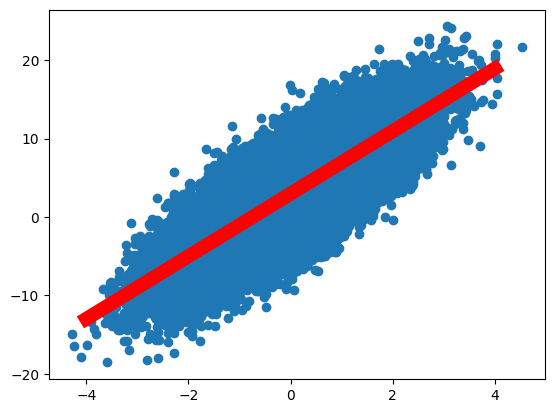

In [16]:
plt.scatter(x, y)
plot_x = np.linspace(-4, 4, 101)
plt.plot(plot_x, reg.predict(plot_x.reshape(-1,1)), c='r', lw=10);

### Полиномиальная регрессия

Полиномиальная регрессия – это форма регрессионного анализа, в которой взаимосвязь между независимой переменной $X$ и зависимой переменной $Y$ моделируется как полином $m$-й степени от $X$

$$Y=f\left(X,\mathbf{w}\right)=w_{0}+w_{1}X+w_{2}X^{2}+...+w_{m}X^{m}+\varepsilon$$

Полиномиальная регрессия может использоваться для решения задачи регрессии для нелинейных данных. В полиномиальной регрессии используется кривая линия, соответствующая полиному степени больше, чем 1. Например, пусть входные данные соответствуют зависимости $y=0.5 x^2+x+2$ (с нормальным шумом):

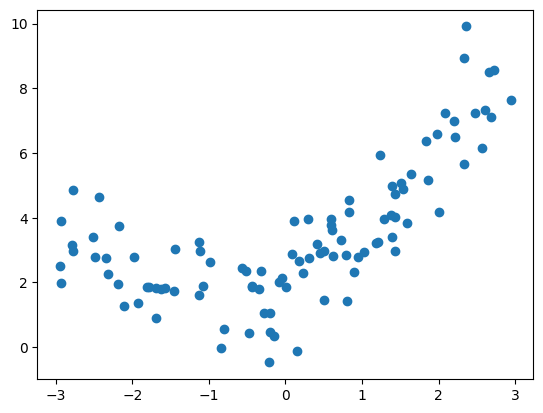

In [17]:
x = np.random.uniform(-3, 3, size=100) # вектор
X = x.reshape(-1, 1)                   # матрица с одним стобцом 
y = 0.5 * x**2 + x + 2 + np.random.normal(0, 1, size=100)

plt.scatter(x, y);

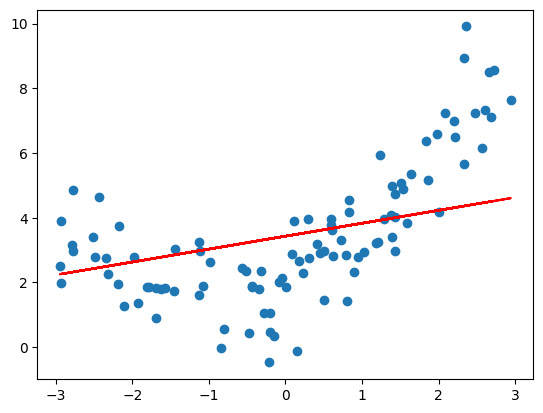

In [18]:
reg = RegressionSGD()
reg.fit(X, y, n_iters=2)
y_predict = reg.predict(X)

plt.scatter(x, y)
plt.plot(x, y_predict, color='r');

Подготовим для модели регрессии входные данные с двумя признаками – линейной и квадратичной зависимостью от независимой переменной:

In [19]:
#1 способ
X2 = np.hstack([X, X**2]) # соединение массивов по горизонтали
X2.shape

(100, 2)

Применим к построенным данным модель регрессии на основе SGD и нарисуем набор данных и линию регрессии (функция `np.argsort` возвращает индексы элементов в отсортированном массиве):

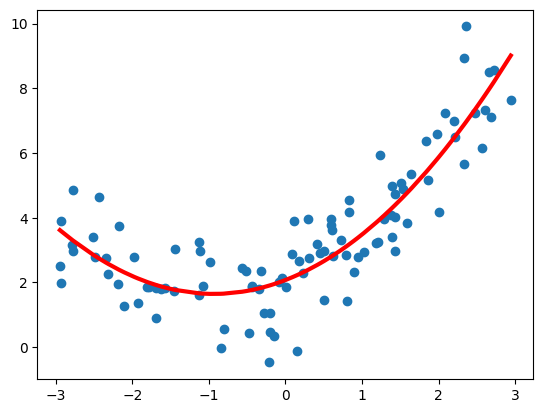

In [20]:
reg2 = RegressionSGD()
reg2.fit(X2, y, n_iters=2000)
y_predict2 = reg2.predict(X2)

plt.scatter(x, y)
plt.plot(np.sort(x), y_predict2[np.argsort(x)], c='r', lw=3); 

Если не использовать функции `sort()` и `argsort()`, то график выглядит так:

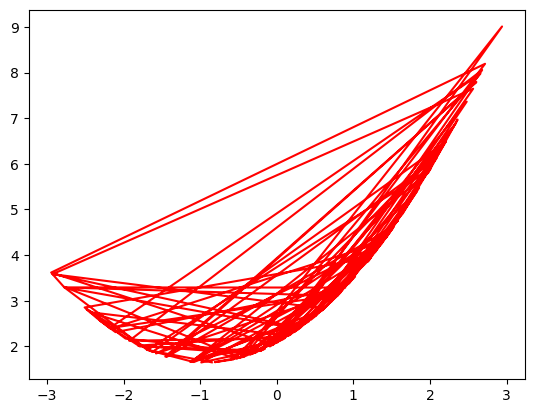

In [21]:
plt.plot(x, y_predict2, c='r');

x и y получены синтетически, они идут в случайном порядке
плот соединяет 2 соседние точки, поэтому так получилось

Определенные при помощи стохастического градиентного спуска коэффициенты регрессии и смещение близки к значениям, использованным при генерации данных:

In [22]:
reg2.coef_, reg2.intercept_

(array([0.91851619, 0.48974248]), 2.075375801705854)

Альтернативный способ построения наборов данных, содержащих полиномиальные зависимости от исходных данных, состоит в применении класса `PolynomialFeatures` из библиотеки `scikit-learn`:

In [24]:
#2 способ
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2) 
poly.fit(X)
X2s = poly.transform(X)
X2s
#1 - константа 1, 2 - х, 3 - х**2

array([[ 1.00000000e+00,  4.53058885e-01,  2.05262353e-01],
       [ 1.00000000e+00,  4.98836261e-01,  2.48837615e-01],
       [ 1.00000000e+00,  8.02723726e-01,  6.44365380e-01],
       [ 1.00000000e+00, -2.17983776e+00,  4.75169267e+00],
       [ 1.00000000e+00,  2.65801764e+00,  7.06505778e+00],
       [ 1.00000000e+00, -4.32158297e-01,  1.86760793e-01],
       [ 1.00000000e+00,  7.97538960e-02,  6.36068393e-03],
       [ 1.00000000e+00,  1.64369339e+00,  2.70172797e+00],
       [ 1.00000000e+00,  2.20351916e+00,  4.85549668e+00],
       [ 1.00000000e+00, -1.62362236e+00,  2.63614957e+00],
       [ 1.00000000e+00, -2.50754286e+00,  6.28777118e+00],
       [ 1.00000000e+00,  1.22908580e+00,  1.51065190e+00],
       [ 1.00000000e+00,  1.18722210e+00,  1.40949631e+00],
       [ 1.00000000e+00,  1.51187534e+00,  2.28576706e+00],
       [ 1.00000000e+00, -1.12499171e+00,  1.26560635e+00],
       [ 1.00000000e+00,  5.08168316e-01,  2.58235038e-01],
       [ 1.00000000e+00,  2.56314484e+00

суперпозиция (нептун)
число слоев- грубина нейрона


### Полиномиальная регрессия при помощи TensorFlow

Полиномиальная регрессия также может быть реализована при помощи `TensorFlow` и `keras`. 

Математически __искусственная нейронная сеть__ (прямого распространения) представляет собой направленный граф с нейронами в качестве вершин и связями между нейронами в виде ребер, причем вход для каждого нейрона является функцией взвешенной суммы выходов всех нейронов, связанных с ним входящими ребрами. Тогда выход нейронной сети равен 

$$\mathbf{f\left(\mathbf{x};\theta\right)=\psi_{d}\left(...\psi_{2}\left(\psi_{1}\left(\mathbf{x}\right)\right)\right),\,\psi_{i}\left(\mathbf{x}\right)=\sigma_{i}\left(\mathbf{w^{\left(i\right)}\,x+b^{\left(i\right)}}\right)}$$

Здесь каждый слой сети представляется __функцией активации__ $\mathbf{\sigma_{i}}$ с аргументом в виде взвешенной суммы входных данных $\mathbf{x}$ с __весами__ $\mathbf{w^{\left(i\right)}}$ и __смещениями__ $\mathbf{b^{\left(i\right)}}$. Число слоев $\mathbf{d}$ называется __глубиной__ нейронной сети и количество нейронов в слое представляет собой __ширину__ этого слоя. 

Целью глубокого обучения является определение набора параметров сети $\mathbf{\theta=\left\{ w^{\left(i\right)},b^{\left(i\right)}\right\} _{i=1}^{d}}$, который минимизирует __функцию потерь__ $\mathbf{\mathcal{L}(\theta)}$, определяющую качество модели при заданном наборе параметров $\theta$. 

Создадим простейшую нейронную сеть с одним слоем из одного нейрона и двумя входными нейронами:

In [25]:
reg2_model = tf.keras.Sequential([
    tf.keras.Input(shape=(2,)),
    tf.keras.layers.Dense(units=1)
])

В такой нейронной сети будет всего три обучаемых параметра (два веса и смещение):

2 входных нейрона с весами и смещение (w(вес)x+b(смещение))

In [26]:
reg2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


При компиляции модели в обязательном порядке указывается функция потерь (`loss`), также может быть выбран оптимизатор с параметрами (`optimizer`), метрики для оценки обучения (`metrics`) и некоторые другие другие параметры. В качестве функции потерь и/или метрики могут быть, в частности,  выбраны среднеквадратичная ошибка (MSE) и средняя абсолютная ошибка (MAE). Коэффициента детерминации $R^2$ среди стандартных функций потерь и метрик нет, но он легко может быть вычислен непосредственно по показателю MSE и общей дисперсии целевой переменной.

In [28]:
reg2_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error') #функция потерь

Обучаем нейронную сеть на полиномиальных зависимостях:

In [29]:
history = reg2_model.fit(
    X2, y, 
    epochs=100,
    # уровень выводимой информации
    verbose=1,
    # проверка (валидация) на 30% обучающих данных
    validation_split = 0.3)

Epoch 1/100
3/3 [==============================] - 1s 100ms/step - loss: 2.4208 - val_loss: 1.9045
Epoch 2/100
3/3 [==============================] - 0s 30ms/step - loss: 1.4440 - val_loss: 1.2895
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 1.2600 - val_loss: 1.0668
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 1.2797 - val_loss: 0.9896
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 1.1656 - val_loss: 1.0137
Epoch 6/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0101 - val_loss: 1.0778
Epoch 7/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9672 - val_loss: 1.1369
Epoch 8/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9343 - val_loss: 1.1170
Epoch 9/100
3/3 [==============================] - 0s 18ms/step - loss: 0.8209 - val_loss: 1.0340
Epoch 10/100
3/3 [==============================] - 0s 18ms/step - loss: 0.7805 - val_loss: 0.9983
Epoch 11/100
3/3 [

Метод `fit` возвращает объект `history`, в котором для задачи регрессии обычно есть ключи `'loss'` и `'val_loss'`. Можно визуализировать историю обучения при помощи следующей функции:

In [30]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylim([0, max(history.history['loss'])*0.5])
  plt.title('Функция потерь при обучении модели')
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Функция потерь')
  plt.legend(['Обучающая выборка', 'Тестовая выборка'], loc='upper right')
  plt.grid(True)

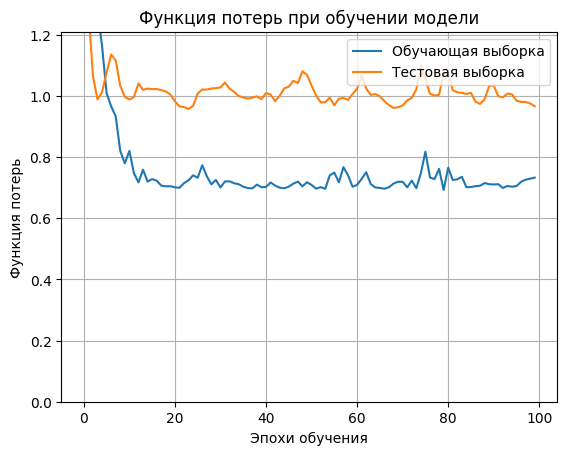

In [32]:
plot_loss(history)

При помощи обученной модели можно выполнить прогноз:

4/4 [==============================] - 0s 6ms/step


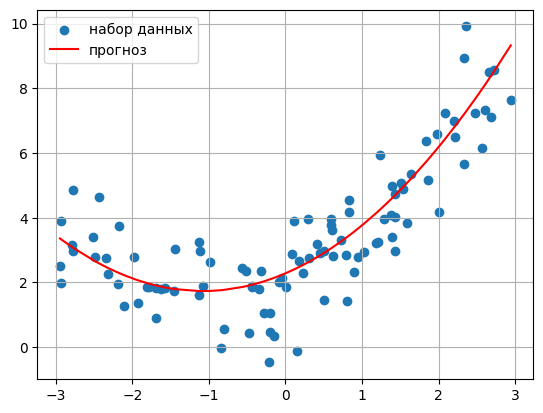

In [33]:
y_predict_reg2 = reg2_model.predict(X2)

plt.scatter(x, y, label='набор данных')
plt.plot(np.sort(x), y_predict_reg2[np.argsort(x)], color='r', label='прогноз')
plt.legend(loc='upper left')
plt.grid();

### Нелинейная парная регрессия при помощи TensorFlow

Универсальная теорема аппроксимации утверждает, что любую непрерывную функцию можно с любой степенью точности аппроксимировать нейронной сетью с одним скрытым слоем с функцией активации сигмоида $\sigma\left(\mathrm{x}\right)=\frac{1}{1+\exp\left(-\mathrm{x}\right)}$.

Построим и обучим нейронную сеть такого типа для рассматриваемого набора данных:

In [34]:
uni_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    tf.keras.layers.Dense(units=512, activation='sigmoid'),
    tf.keras.layers.Dense(units=1)
])

In [35]:
uni_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               1024      
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [36]:
uni_model.compile(loss='mse', 
                  optimizer=tf.optimizers.Adam(learning_rate=0.1),
                  metrics=['mae'])

In [37]:
X.shape

(100, 1)

In [38]:
history = uni_model.fit(
    X, y, 
    epochs=100,
    # уровень выводимой информации
    verbose=1,
    # проверка (валидация) на 20% обучающих данных
    validation_split = 0.2)

Epoch 1/100
3/3 [==============================] - 1s 90ms/step - loss: 223.0969 - mae: 11.6830 - val_loss: 90.2283 - val_mae: 9.2947
Epoch 2/100
3/3 [==============================] - 0s 27ms/step - loss: 189.1643 - mae: 13.3267 - val_loss: 62.7687 - val_mae: 7.6531
Epoch 3/100
3/3 [==============================] - 0s 28ms/step - loss: 29.9067 - mae: 4.4343 - val_loss: 101.6548 - val_mae: 9.9318
Epoch 4/100
3/3 [==============================] - 0s 21ms/step - loss: 98.5375 - mae: 9.7732 - val_loss: 51.0266 - val_mae: 6.7733
Epoch 5/100
3/3 [==============================] - 0s 29ms/step - loss: 21.3165 - mae: 3.9866 - val_loss: 18.2910 - val_mae: 3.4852
Epoch 6/100
3/3 [==============================] - 0s 30ms/step - loss: 30.3732 - mae: 5.0812 - val_loss: 46.0436 - val_mae: 6.3354
Epoch 7/100
3/3 [==============================] - 0s 28ms/step - loss: 35.2292 - mae: 5.6378 - val_loss: 11.9675 - val_mae: 2.6592
Epoch 8/100
3/3 [==============================] - 0s 20ms/step - loss:

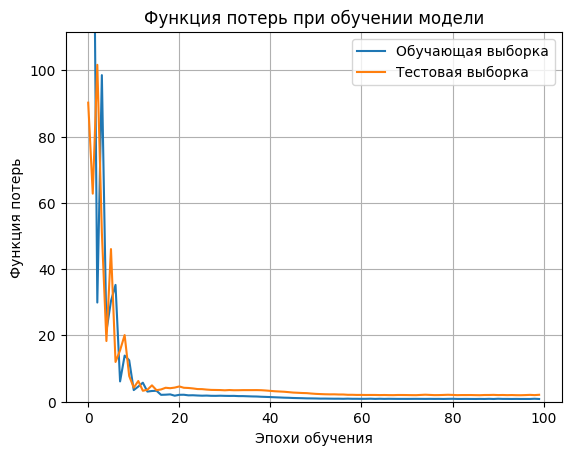

In [39]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


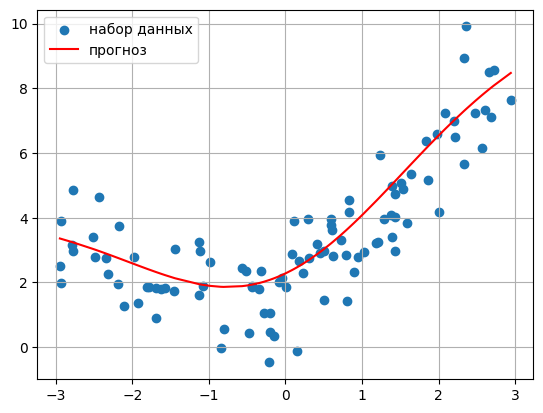

In [40]:
y_predict_uni = uni_model.predict(X)

plt.scatter(x, y, label='набор данных')
plt.plot(np.sort(x), y_predict_uni[np.argsort(x)], color='r', label='прогноз')
plt.legend(loc='upper left')
plt.grid();

### Нелинейная множественная регрессия при помощи TensorFlow

При помощи нейронных сетей с нелинейными функциями активации нейронов можно успешно решать задачи нелинейной регрессии.

Загрузим из TesorFlow Datasets набор `howell` с демографическими данными жителей Калахари:

In [41]:
ds = tfds.load("howell", split='train')
df = tfds.as_dataframe(ds)
df

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/howell/1.0.0.incomplete99O5NO/howell-train.tfrecord*...:   0%|          | …

Dataset howell downloaded and prepared to /root/tensorflow_datasets/howell/1.0.0. Subsequent calls will reuse this data.


,age,height,male,weight
0,20.000000,154.899994,1,38.200001
1,21.000000,155.574997,0,45.529297
2,21.000000,146.050003,0,44.763859
3,21.000000,163.830002,1,46.776676
4,18.000000,149.225006,0,42.127357
5,5.000000,101.599998,0,15.337079
6,25.000000,147.320007,0,48.959587
7,38.000000,147.320007,0,51.255898
8,1.000000,60.452000,1,5.669900
9,29.000000,144.779999,0,38.045029


Изучим зависимость возраста от роста и веса:

In [42]:
X = np.array(df[['height','weight']])
y = np.array(df[['age']]).reshape(-1)

In [43]:
X.shape, y.shape

((544, 2), (544,))

### Визуализация трехмерных данных

Для построения 3d графиков необходимо импортировать необходимые модули:

In [44]:
from mpl_toolkits import mplot3d
# или from mpl_toolkits.mplot3d import Axes3D

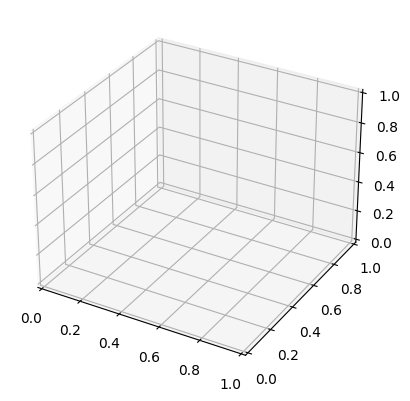

In [45]:
fig = plt.figure()
ax = plt.axes(projection='3d') # или ax = fig.add_subplot(111, projection='3d')

Для построения точечного графика можно использовать функцию `scatter()`, которой передаются три параметра для координат точек по осям X, Y и Z.

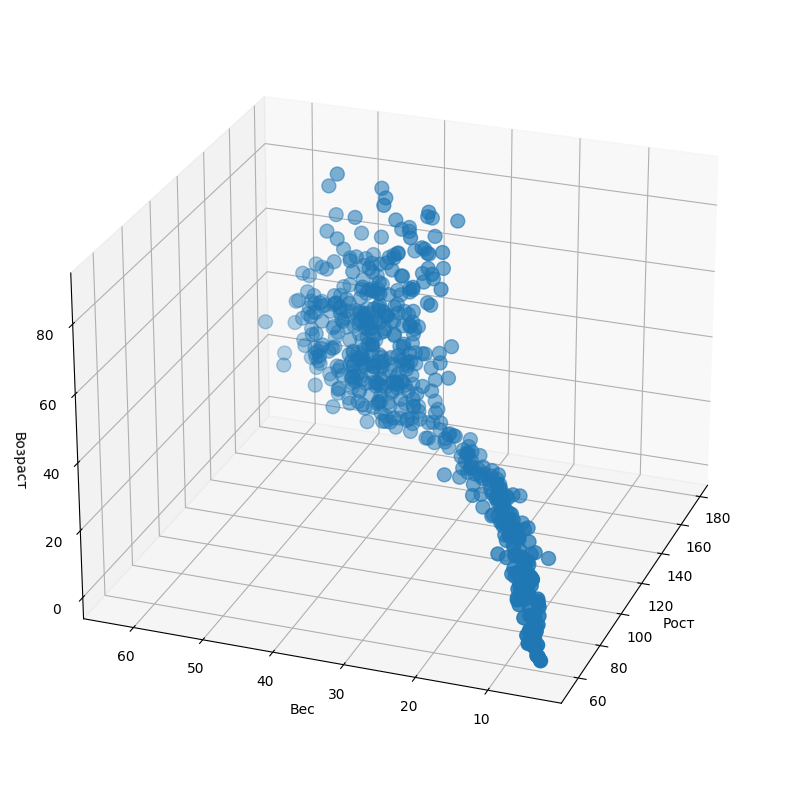

In [51]:
fig = plt.figure(figsize=(12,10)) 
ax = plt.axes(projection='3d') 

xs = X[:,0]
ys = X[:,1]
zs = y

ax.scatter( xs, ys, zs, s=100 ) 
ax.set_xlabel('Рост') 
ax.set_ylabel('Вес') 
ax.set_zlabel('Возраст') 
ax.view_init( azim=-160, elev=25 )

### Глубокая нейронная сеть для задачи регрессии

Используем слой нормализации, адаптированный к обоим независимым признакам:

In [47]:
feature_normalizer = tf.keras.layers.Normalization(axis=None,input_shape=(2,)) 
feature_normalizer.adapt(X)

Создадим нейронную сеть со слоем нормализации, четырьмя скрытыми плотными слоями с 64 нейронами и функцией активации ReLu и выходным слоем из одного нейрона:

In [48]:
large_model = tf.keras.Sequential([
    feature_normalizer,
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1) #слой с 1 нейроном
])

large_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                3         
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                192       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                      

Скомпилируем модель, используя в качестве функции потерь  среднеквадратичную ошибку MSE с оптимизатором по умолчанию (RmsProp):

In [53]:
large_model.compile(loss='mse')

Обучим модель на наборе данных из двух признаков:

In [58]:
history = large_model.fit(
    X, y, 
    epochs=100,
    # уровень выводимой информации
    verbose=1,
    # проверка (валидация) на 30% обучающих данных
    validation_split = 0.3)

Epoch 1/100
12/12 [==============================] - 0s 11ms/step - loss: 196.6637 - val_loss: 200.5441
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 193.3348 - val_loss: 197.4494
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 194.6561 - val_loss: 197.0694
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 194.1932 - val_loss: 192.6748
Epoch 5/100
12/12 [==============================] - 0s 7ms/step - loss: 194.6579 - val_loss: 202.1314
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 195.9961 - val_loss: 197.5437
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 194.8489 - val_loss: 198.4921
Epoch 8/100
12/12 [==============================] - 0s 7ms/step - loss: 196.2227 - val_loss: 191.8843
Epoch 9/100
12/12 [==============================] - 0s 6ms/step - loss: 192.3031 - val_loss: 191.7689
Epoch 10/100
12/12 [==============================] - 0s 7ms/step - loss

Кривые обучения в зависимости от эпохи обучения выглядят так:

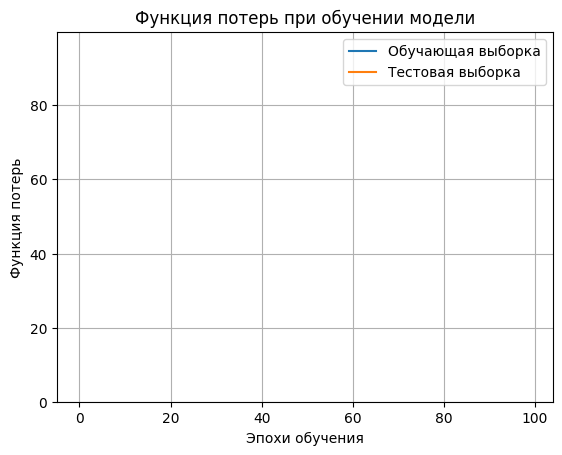

In [59]:
plot_loss(history)

Для визуализации прогнозируемых множественной регрессией значений воспользуемся функцией `plot_surface`. Потребуются определенные усилия по подготовке данных для `plot_surface`:

In [61]:
n_plot = 51 #матрица 51 на 51 и мы смотрим на узлы. строим поверхность по сетке

x_plot = np.linspace(np.min(xs), np.max(xs), n_plot) 
y_plot = np.linspace(np.min(ys), np.max(ys), n_plot)

In [62]:
x_mesh, y_mesh = np.meshgrid(x_plot, y_plot) #готовит данные для 3д визуализации
x_mesh.shape, y_mesh.shape

((51, 51), (51, 51))

In [63]:
x_plot2 = np.reshape(x_mesh, [n_plot**2,1])
y_plot2 = np.reshape(y_mesh, [n_plot**2,1])
xy_2 = np.hstack([x_plot2, y_plot2])
xy_2.shape

(2601, 2)

Теперь выполним прогнозирование при помощи обученной ранее модели, после чего вернемся к форме данных 51 на 51:

In [64]:
z = large_model.predict(xy_2)
z.shape

82/82 [==============================] - 0s 2ms/step


(2601, 1)

In [65]:
z_mesh = z.reshape((n_plot, n_plot))
z_mesh.shape

(51, 51)

Функция `plot_surface` имеет большое число параметров, в частности:

* X, Y, Z : 2D массивы – данные для построения поверхности.
* rstride, cstride : int – параметры определяют величину шага, с которым будут браться элементы строки/столбца из переданных массивов.
* cmap: Colormap – цветовая карта для элементов поверхности.


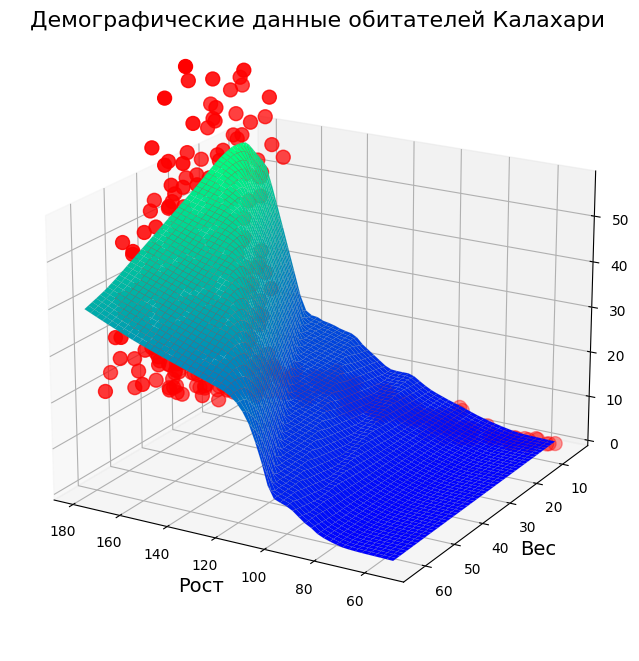

In [66]:
from matplotlib import cm

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x_mesh, y_mesh, z_mesh, \
       rstride=1, cstride=1, linewidth=0.05, cmap=cm.winter, antialiased=True, \
       edgecolors='gray') 
ax.scatter( xs, ys, zs, s=100, c='r' )

ax.set_xlabel('Рост', fontsize=14) 
ax.set_ylabel('Вес', fontsize=14)
ax.set_zlabel('Возраст', fontsize=14) 
ax.set_title('Демографические данные обитателей Калахари', fontsize=16)

ax.set_zlim(0., z_mesh.max())
ax.view_init(elev = 20, azim = 120)

__Кривые обучения__ — это графическое представление зависимости меры (показателя) качества обучения (по вертикальной оси) от определенного показателя модели обучения (по горизонтальной оси). Будем визуализировать в качестве качества модели показатели RMSE для части обучающей выборки и тестовой выборки в зависимости от количества точек в обучающей выборке.

Для разбиения на обучающую и тестовую выборки можно использовать функцию `train_test_split`:

In [67]:
def train_test_split(X, y, test_ratio=0.2, seed=None):
    """возвращает X_train, X_test, y_train, y_test"""
    assert X.shape[0] == y.shape[0], \
        "Размер X должен быть равен размеру y"
    assert 0.0 <= test_ratio <= 1.0, \
        "Неверное значение test_ratio"

    if seed:
        np.random.seed(seed)

    shuffled_indexes = np.random.permutation(len(X))

    test_size = int(len(X) * test_ratio)
    test_indexes = shuffled_indexes[:test_size]
    train_indexes = shuffled_indexes[test_size:]

    X_train = X[train_indexes]
    y_train = y[train_indexes]

    X_test = X[test_indexes]
    y_test = y[test_indexes]

    return X_train, X_test, y_train, y_test

Разобьем массивы данных `X` и `y` на обучающие и тестовые данные:

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((381, 2), (163, 2), (381,), (163,))

Будем использовать для визуализации показатель RMSE:

In [69]:
def my_rmse(y_test, y_predict):
    return np.sqrt(np.sum((y_predict - y_test)**2) / len(y_test))

Всего в обучающей выборке 381 точка, начнем с 11 точек и будем прибавлять по 10 точек на каждом шаге цикла:

In [70]:
train_score = []
test_score = []
for i in range(11, 381, 10):
    large_model = tf.keras.Sequential([
        feature_normalizer,
#        tf.keras.layers.Dense(units=64, activation='relu'),
#        tf.keras.layers.Dense(units=64, activation='relu'),
#        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=1)
    ])
    large_model.compile(loss='mse')
    large_model.fit(X_train[:i], y_train[:i], epochs=50, verbose=0)

    y_train_predict = large_model.predict(X_train[:i])
    train_score.append(my_rmse(y_train[:i], y_train_predict))
    
    y_test_predict = large_model.predict(X_test)
    test_score.append(my_rmse(y_test, y_test_predict))
    print('-->', i, ' done')

6/6 [==============================] - 0s 3ms/step
--> 11  done
6/6 [==============================] - 0s 2ms/step
--> 21  done
6/6 [==============================] - 0s 2ms/step
--> 31  done
6/6 [==============================] - 0s 2ms/step
--> 41  done
6/6 [==============================] - 0s 2ms/step
--> 51  done
6/6 [==============================] - 0s 2ms/step
--> 61  done
6/6 [==============================] - 0s 2ms/step
--> 71  done
6/6 [==============================] - 0s 3ms/step
--> 81  done
6/6 [==============================] - 0s 3ms/step
--> 91  done
6/6 [==============================] - 0s 3ms/step
--> 101  done
6/6 [==============================] - 0s 4ms/step
--> 111  done
6/6 [==============================] - 0s 4ms/step
--> 121  done
6/6 [==============================] - 0s 7ms/step
--> 131  done
6/6 [==============================] - 0s 3ms/step
--> 141  done
6/6 [==============================] - 0s 5ms/step
--> 151  done
6/6 [=============================

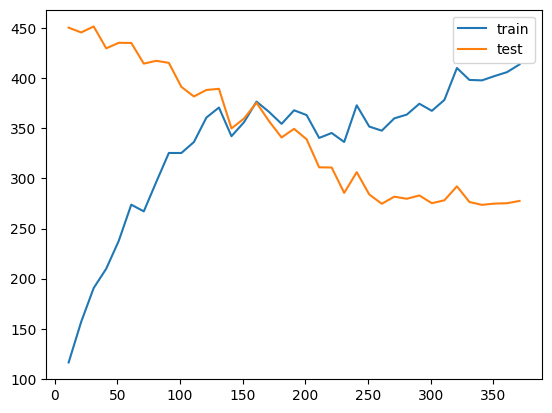

In [71]:
plt.plot([i for i in range(11, len(X_train), 10)], 
                               train_score, label="train")
plt.plot([i for i in range(11, len(X_train), 10)], 
                               test_score, label="test")
plt.legend();

#### Задание (10 баллов)

Для закрепленного за Вами варианта лабораторной работы:

1.	Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets, включая указанные в задании независимый признак и зависимый признак (отклик).

2.	Решите задачу полиномиальной регрессии для степени полинома, указанной в индивидуальном задании, при помощи нейронной сети с одним нейроном и оцените качество полученной модели по показателю, указанному в индивидуальном задании. 

3.	Постройте кривые обучения с зависимостью от количества эпох.

4.	Визуализируйте точки набора данных на плоскости в виде диаграммы рассеяния (ось X – независимый признак, ось Y – зависимый признак), а также линию регрессии (другим цветом), подписывая оси и рисунок. 

5.	Определите в исходном наборе данных признак (отличный от независимого и зависимого признаков), принимающий непрерывные значения и имеющий свойства, указанные в индивидуальном задании. 

6.	Визуализируйте этот признак в соответствии с индивидуальным заданием. 

7.	Сформируйте набор входных данных из двух признаков набора данных (независимый признак и определенный признак), создайте и адаптируйте нормализующий слой Tensorflow для двух признаков. 

8.	Используя созданный нормализующий слой, постройте нейронную сеть (нелинейный регресор) с количеством скрытых слоев, количеством нейронов и функцией активации, указанными в индивидуальном задании, и одним нейроном в выходном слое и обучите ее на наборе данных из двух признаков и отклика. 

9.	Визуализируйте набор данных в виде точечного графика и прогноз нейронной сети в виде поверхности в трехмерном пространстве.

10.	Разбейте набор данных из двух признаков и отклика на обучающую и тестовую выборки и постройте кривые обучения для заданного показателя качества в зависимости от количества точек в обучающей выборке, подписывая оси и рисунок и создавая легенду.

